In [ ]:
import pandas as pd


In [ ]:
##This is version 1.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
image_dir = "/content/drive/MyDrive/brain_tumor_dataset/brisc2025/segmentation_task/train/images"
mask_dir = "/content/drive/MyDrive/brain_tumor_dataset/brisc2025/segmentation_task/train/masks"

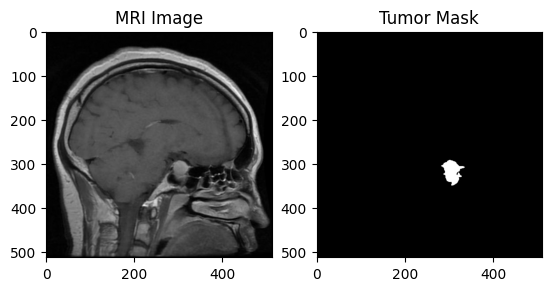

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

img_path = f"{image_dir}/brisc2025_train_05000_pi_sa_t1.jpg"
mask_path = f"{mask_dir}/brisc2025_train_05000_pi_sa_t1.png"

image = Image.open(img_path).convert("L")
mask = Image.open(mask_path).convert("L")

plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")
plt.title("MRI Image")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="gray")
plt.title("Tumor Mask")

plt.show()


In [ ]:
# 2. Imports & Device Setup
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
# 3. U-Net Model Definition
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        self.bottleneck = DoubleConv(512, 1024)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64)
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(nn.MaxPool2d(2)(e1))
        e3 = self.enc3(nn.MaxPool2d(2)(e2))
        e4 = self.enc4(nn.MaxPool2d(2)(e3))
        b = self.bottleneck(nn.MaxPool2d(2)(e4))
        d4 = self.dec4(torch.cat([self.upconv4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.upconv3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.upconv2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.upconv1(d2), e1], dim=1))
        return torch.sigmoid(self.final(d1))


In [ ]:
print("Images:", os.listdir(image_dir)[:5])
print("Masks :", os.listdir(mask_dir)[:5])


Images: ['brisc2025_train_03999_pi_co_t1.jpg', 'brisc2025_train_04071_pi_co_t1.jpg', 'brisc2025_train_03972_pi_co_t1.jpg', 'brisc2025_train_04096_pi_co_t1.jpg', 'brisc2025_train_03984_pi_co_t1.jpg']
Masks : ['brisc2025_train_04020_pi_co_t1.png', 'brisc2025_train_03947_pi_ax_t1.png', 'brisc2025_train_03998_pi_co_t1.png', 'brisc2025_train_03952_pi_ax_t1.png', 'brisc2025_train_04026_pi_co_t1.png']


In [ ]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
import torch

class BrainTumorDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_size=(256, 256), transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_size = image_size
        self.transform = transform
        self.image_transform = transforms.ToTensor()
        self.mask_transform = transforms.ToTensor()

        image_files = sorted(os.listdir(self.image_dir))
        mask_files = sorted(os.listdir(self.mask_dir))

        def get_key(filename):
            return filename[:22]  # adjust if needed

        image_dict = {get_key(f): f for f in image_files}
        mask_dict = {get_key(f): f for f in mask_files}

        self.keys = list(set(image_dict.keys()) & set(mask_dict.keys()))
        self.image_files = [image_dict[k] for k in self.keys]
        self.mask_files = [mask_dict[k] for k in self.keys]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        # Resize both to the same target size
        image = image.resize(self.image_size, Image.BILINEAR)
        mask = mask.resize(self.image_size, Image.NEAREST)

        # Apply any custom transform
        if self.transform:
            image = self.transform(image)
            mask = self.mask_transform(mask)
            mask = (mask > 0.5).long().squeeze(0)
        else:
            image = TF.to_tensor(image)

        mask = torch.from_numpy(np.array(mask)).long()

        return image, mask


In [ ]:
class DiceLoss(nn.Module):
    def forward(self, inputs, targets, smooth=1):
        # Apply sigmoid to get probabilities
        inputs = torch.sigmoid(inputs)

        # Flatten
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # Dice computation
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice


In [ ]:
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        dice_loss = DiceLoss()(inputs, targets)
        return 0.5*bce_loss + 0.5*dice_loss




In [ ]:
import os

image_dir = "/content/drive/MyDrive/brain_tumor_dataset/brisc2025/segmentation_task/train/images"
mask_dir = "/content/drive/MyDrive/brain_tumor_dataset/brisc2025/segmentation_task/train/masks"

image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

print("Images:", len(image_files))
print("Masks :", len(mask_files))

# Check if names match
print("First image:", image_files[0] if image_files else "None")
print("First mask :", mask_files[0] if mask_files else "None")


Images: 3933
Masks : 3933
First image: brisc2025_train_00001_gl_ax_t1.jpg
First mask : brisc2025_train_00001_gl_ax_t1.png


In [ ]:
# 6. Training Setup
image_dir = "/content/drive/MyDrive/brain_tumor_dataset/brisc2025/segmentation_task/train/images"
mask_dir = "/content/drive/MyDrive/brain_tumor_dataset/brisc2025/segmentation_task/train/masks"
from torchvision import transforms

transform = transforms.ToTensor()  # PIL Image --> Tensor

dataset = BrainTumorDataset(image_dir, mask_dir, transform=transform)

loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)

print(len(loader))


model = UNet().to(device)
criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
print('ye')
##for images, masks, filenames in loader:

    ##print("Batch filenames:", filenames)  # See which files are in this batch
    ##break  # Just for checking one batch


984
ye


In [ ]:
# 7. Save Predictions Function
def save_predictions(images, outputs, masks, save_dir="predictions", threshold=0.5):
    os.makedirs(save_dir, exist_ok=True)
    for idx in range(images.size(0)):
        binary_mask = (outputs[idx] > threshold).float()
        save_image(binary_mask, f"{save_dir}/pred_{idx}.png")
        save_image(images[idx], f"{save_dir}/input_{idx}.png")
        save_image(masks[idx], f"{save_dir}/mask_{idx}.png")


In [ ]:
from torchvision.utils import make_grid
import torchvision.transforms.functional as TF

def save_predictions(images, preds, masks, save_dir):
    os.makedirs(save_dir, exist_ok=True)

    # Make sure all are float and detached before conversion
    images = images.detach().cpu()
    preds = preds.detach().cpu().float()
    masks = masks.detach().cpu().float()

    # Combine all tensors into a grid (optionally normalize)
    grid = make_grid(torch.cat([images, preds.unsqueeze(1), masks.unsqueeze(1)], dim=0), nrow=images.shape[0])

    # Safely convert to uint8 for saving
    ndarr = (grid * 255).clamp(0, 255).byte().permute(1, 2, 0).numpy()

    # Save using PIL
    Image.fromarray(ndarr).save(os.path.join(save_dir, 'batch_result.png'))


In [ ]:
# 8. Training Loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, masks in loader:

        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(loader):.4f}")

    # Save predictions on first batch
    model.eval()
    with torch.no_grad():
      for images, masks in loader:
          images = images.to(device)  # [B, 1, H, W]
          masks = masks.to(device)    # [B, H, W], Long

          outputs = model(images)     # [B, C, H, W]
          preds = torch.argmax(outputs, dim=1)  # [B, H, W], Long

          save_predictions(
              images.cpu(),
              preds.cpu(),
              masks.cpu(),
              save_dir=f"predictions/epoch_{epoch+1}"
          )
          break



Epoch [1/10], Loss: 0.9600
Epoch [2/10], Loss: 0.9575
Epoch [3/10], Loss: 0.9563
Epoch [4/10], Loss: 0.9560
Epoch [5/10], Loss: 0.9557
